## **Load in data**

In [64]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pylab
from random import random

from GP import * 
from vis import *
from data import * 

# Outputs are t, y, ttrue, ytrue
t, y, ttrue, ytrue = loadData()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Index(['Update Date and Time (ISO)', 'Update Duration (ms)',
       'Reading Date and Time (ISO)', 'Air pressure (mb)',
       'Air temperature (C)', 'Tide height (m)', 'Wind direction (deg)',
       'Wind gust speed (kn)', 'Wind speed (kn)', 'True air temperature (C)',
       'True tide height (m)', 'Independent tide height prediction (m)',
       'Independent tide height deviation (m)',
       'Dependent tide height prediction (m)',
       'Dependent tide height deviation (m)',
       'Independent air temperature prediction (C)',
       'Independent air temperature deviation (C)',
       'Dependent air temperature prediction (C)',
       'Dependent air temperature deviation (C)'],
      dtype='object')


## **Initial Test**

Hyperparameters chosen manually to provide a reasonable fit to the data, using a summed RBF kernel and periodic kernel.


Could not compute RMSE: unequal input sizes
Log marginal likelihood: -1532.3630460462168
RMSE:  0





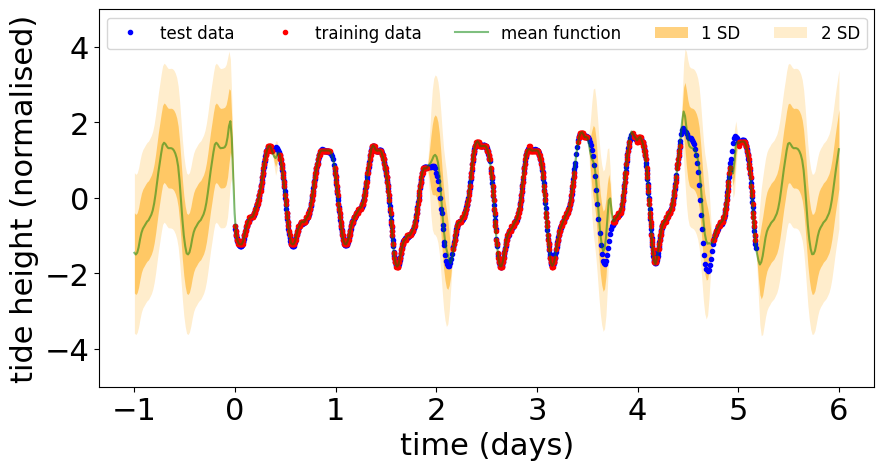

In [70]:

# Input data for GP
X = t
Y = y 
Xs = np.linspace(-1, 6, 500).reshape(-1,1) 
# Xs = ttrue

# Initial guess for model parameters
sigma_rbf = 1.0 # RBF kernel
L_rbf = 0.03

sigma_per = 10  #
L_per = 0.1
p_per = 0.5175

jitter = 0.01


# Parameters from optimizer result
# jitter, sigma_rbf, L_rbf, sigma_per, L_per, p_per = 0.02313429, -0.32364286,  0.46129201,  0.62726026,  0.80954964,  0.51560234

# Build the kernel function
params = [sigma_rbf, L_rbf, sigma_per, L_per, p_per]
kernel = buildKernel(params, jitter)

# Mean and covariance functions
mu = np.zeros(len(X))
K = kernel(X, X)

# Posterior predictive distribution
mu, sigma, LML = getPosteriorPredictive(X, Y, Xs, kernel, jitter)

# Compute RMSE
RMSE = getRMSE(mu, ytrue)

# Printouts
print("Log marginal likelihood:", LML)
print('RMSE: ', RMSE)

# Visualisation
plotTides(Xs, mu, sigma, t, y, ttrue, ytrue)



## Optimisation of Log Marginal Likelihood


Length comp: 917 60
LML: 31.803584925976303
LML: 31.803580985902308
LML: 31.803586989508624
LML: 31.803585009252593
LML: 31.803585568146126
LML: 31.803585282477563
LML: 22.17735005564017
LML: 22.17735117998364
LML: 22.17735130233421
LML: 22.177350020551422
LML: 22.177350107336757
LML: 22.177350092735814
LML: 70.84376922520144
LML: 70.84377282963294
LML: 70.843770349251
LML: 70.84376926487383
LML: 70.84376976957876
LML: 70.84376956181504
LML: -80.27930397753485
LML: -80.27935444145231
LML: -80.27930561628546
LML: -80.27930359217402
LML: -80.27930470873818
LML: -80.27930468350951
LML: 78.87712886311141
LML: 78.87712947792997
LML: 78.87712897629814
LML: 78.87712889160173
LML: 78.87712930593202
LML: 78.8771291580781
LML: 78.83000339594145
LML: 78.83000447211734
LML: 78.83000384160559
LML: 78.83000357405462
LML: 78.83000321482064
LML: 78.83000321517869
LML: 82.46208433441723
LML: 82.46208573958728
LML: 82.46208460485622
LML: 82.46208442283046
LML: 82.46208438292982
LML: 82.46208437805058
LM

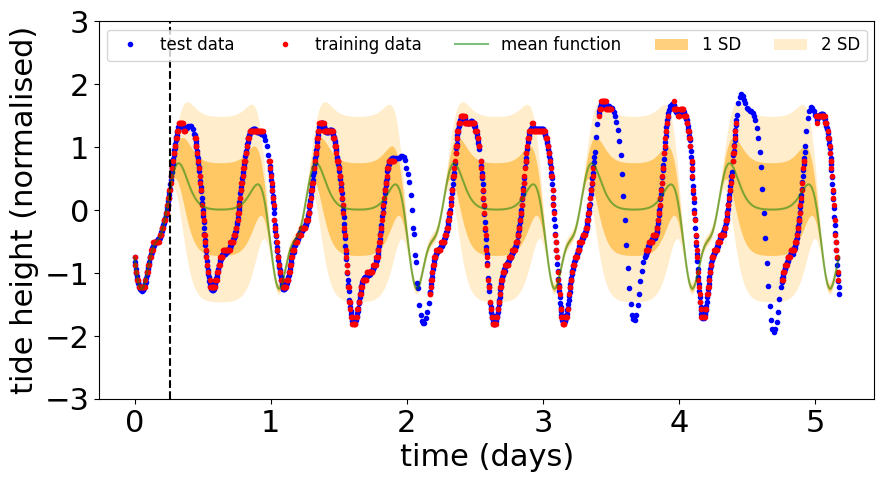

In [15]:
# Input data for GP
X = t
Y = y 
Xs = np.linspace(-1, 10, 500).reshape(-1,1) 
Xs = ttrue

# Initial guess for model parameters
sigma_rbf = 0.5 # RBF kernel
L_rbf = 0.2

sigma_per = 1  # periodic kernel
L_per = 0.4
p_per = 0.5175

jitter = 0.01

# init_guess = [jitter, sigma_rbf, L_rbf, sigma_per, L_per, p_per]
init_guess = [random() for _ in range(5)]

max_iter = 10
time_cutoff = 0.05 # 1.0 = use all data

Xc, Yc = truncateData(X, Y, time_cutoff)
print("Length comp:", len(X), len(Xc))

result = minimize(
            optimizerFunction, 
            init_guess, 
            args=(Xc, Yc, Xs, jitter), 
            method='BFGS', 
            tol=0.01,
            options={"maxiter":max_iter, "disp":True}
            )


print("initial guess: ", init_guess)
    
print("final parameters: ", end='')
print(*result.x, sep=',')

# Build the kernel function
params = result.x
kernel = buildKernel(params, jitter)

# Posterior predictive distribution
jitter = params[0]
mu, sigma, LML = getPosteriorPredictive(Xc, Yc, Xs, kernel, jitter)

# Compute RMSE
RMSE = getRMSE(mu, ytrue)

# Printouts
print("Log marginal likelihood:", LML)
print('RMSE: ', RMSE)

# Visualisation
plotTides(Xs, mu, sigma, t, y, ttrue, ytrue, time_cutoff)

## Look-ahead experiments

We choose some lookahead time $\delta_t$. Then, for each available data point at time $t$ in the ground truth dataset, we try to predict its value using only data from before time $t - \delta_t$.

Finished iteration 100 of 1258
Finished iteration 200 of 1258
Finished iteration 300 of 1258
Finished iteration 400 of 1258
Finished iteration 500 of 1258
Finished iteration 600 of 1258
Finished iteration 700 of 1258
Finished iteration 800 of 1258
Finished iteration 900 of 1258
Finished iteration 1000 of 1258
Finished iteration 1100 of 1258
Finished iteration 1200 of 1258





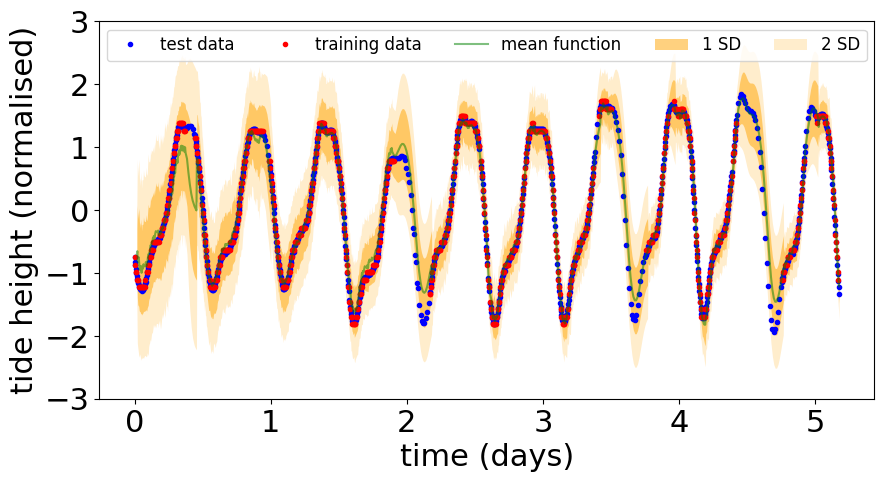

In [5]:
# Lookahead period in minutes
lookahead = 15 # 3*24*60
dt = lookahead / (60 * 24) # days

# Total available data
pts = len(ttrue)

# Start predicting from the nth datapoint onwards
first = 1

# Plotting arrays
tvals = ttrue[first-1:]
yvals, muvals, sigmavals, Xsvals= np.array([]), np.array([]), np.array([]), np.array([])

# Progress printing
pskip = 100

# Predict tide height at each time t based only on data from time t-dt or earlier
for i in range(first-1, pts):

    # Progress printout
    iter = i - first + 1
    if iter > 0 and iter % pskip == 0:
        print("Finished iteration", i-first+1, "of", pts-first+1)
    
    # Time to predict for
    target_time = ttrue[i]

    # Find latest data point to use for lookahead
    j = 0
    while j < len(t) and t[j] + dt < target_time:
        j += 1

    # Too early in dataset to look ahead - skip
    if ttrue[i] < dt or j == 0: 
        continue 

    # Extract data used for lookahead
    X = t[:j]
    Y = y[:j]

    # Target X* is a single point
    Xs = np.array([target_time])

    # Build kernel
    params = [0.01, 0.5, 0.2, 1.0, 0.4, 0.5175]
    kernel = buildKernel(params)

    # Posterior predictive distribution
    jitter = params[0]
    mu, sigma, LML = getPosteriorPredictive(X, Y, Xs, kernel, jitter)

    # Sanity checking
     # jj = 0
    # while t[jj] < target_time:
    #     jj += 1

   # print(t[jj], target_time) # should be always equal
    # print("Time lookahead gap (hrs): ", 24 * (target_time - X[-1])) # check lookahead time
    # print("Compare:", mu, ytrue[jj])

    # Store variables for plotting
    ii = i - first + 1
    muvals = np.append(muvals, mu)
    sigmavals = np.append(sigmavals, sigma)
    Xsvals = np.append(Xsvals, Xs)

# For the covariance matrix, we are interested in the diagonal terms only 
sigma_matrix = np.diag(sigmavals)

# Visualisation
plotTides(Xsvals, muvals, sigma_matrix, t, y, ttrue, ytrue)

